# Работа с данными. Домашнее задание


## Задача
Имеется набор данных покупателей супермаркета. Проведите анализ и очистку этих данных.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

### Задание 1

Загрузите данные из файла `Mall_Customers.csv` в ноутбук и выведите первые пять строк на экран.

In [2]:
# Загрузка данных из файла
df = pd.read_csv("Mall_Customers.csv")

In [3]:
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19.0,15.0,39
1,2,Male,NaN,NaN,81
2,3,Female,NaN,16.0,6
3,4,Female,23.0,16.0,77
4,5,Female,31.0,17.0,40


### Описание данных

Дан файл Mall_Customers.csv, содержащий следующие данные по покупателям сети супермаркетов:
- CustomerID — идентификатор покупателя.
- Genre – пол покупателя.
- Age – возраст покупателя.
- Annual Income (k\$) – годовой доход покупателя, тысяч $.
- Spending Score (1–100) – рейтинг покупателя, целевая переменная.

### Задание 2

Проведите разведочный анализ загруженных данных. Обязательные атрибуты для анализа:
- количество пропусков в каждом признаке;
- распределения признаков;
- возможные выбросы или аномалии.

Анализ дополнительных атрибутов и свойств данных приветствуется. Используйте средства визуализации там, где это необходимо.

По результатам анализа сделайте выводы о свойствах отдельных признаков и качестве данных в целом.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CustomerID              200 non-null    int64  
 1   Genre                   181 non-null    object 
 2   Age                     180 non-null    float64
 3   Annual Income (k$)      180 non-null    float64
 4   Spending Score (1-100)  200 non-null    int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 7.9+ KB


Из общей информации df следует:
1. DataFrame содержит 200 записей (от индекса 0 до 199)
2. Всего 5 колонок
3. Нулевые значения отсуствуют
4. Пропущенные значения в колонках Genre, Age, Annual Income
5. Колонки CustomerID, Spending Score, в формате int64, Age, Annual Income в формате float64 и один объектный Genre

In [5]:
# Статистический анализ числовых переменных
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,200.0,100.500000,57.879185,1.0,50.75,100.5,150.25,200.0
Age,180.0,39.894444,16.842848,18.0,29.00,36.0,49.00,135.0
Annual Income (k$),180.0,5615.433333,74531.115872,15.0,42.00,61.0,78.00,1000000.0
Spending Score (1-100),200.0,50.200000,25.823522,1.0,34.75,50.0,73.00,99.0


На основе представленных статистических данных неприрывных признаков можно сделать следующие выводы:

Age (Возвраст покупателя):

- Средний возвраст на уровне 36.00
- Миниманая 18.00
- Максимальная 135.00
- Медиана равна 39.89
- Отклонение состовляет 16.84

Annual Income (Годовой доход покупателя):

- Средний доход на уровне 61.00
- Миниманая 15.00
- Максимальная 1000000.00
- Медиана равна 5615.43
- Отклонение состовляет 74531.11

Spending Score (Рейтинг покупателя):

- Средний рейтинг на уровне 50.00
- Миниманая 99.00
- Максимальная 1.00
- Медиана равна 50.20
- Отклонение состовляет 25.82

CustomerID - уникальный номер клиента не учитываем.
Данные имею выбросы и неравномерность.

In [6]:
# Статистический анализ объектных переменных
df.describe(include='object').T

,count,unique,top,freq
Genre,181,3,Female,102



Genre (Пол покупателя):

В данных присутствуют записи о поле у 181 записей.
Имеются три уникальные записи о поле покупателя.
Наиболее часто встречающийся запись - Female, с частотой 102 раз.

In [7]:
# Проверка на дубликаты
duplicate_df = df[df.duplicated()]
print("number of duplicate rows: ", duplicate_df.shape)

number of duplicate rows:  (0, 5)


Дубликатов не обнаружено.

In [8]:
# Проверка на NaN значения
df.isnull().any().any()

True

In [9]:
# Проверка на нулевые значения
df.isnull().sum()

CustomerID                 0
Genre                     19
Age                       20
Annual Income (k$)        20
Spending Score (1-100)     0
dtype: int64

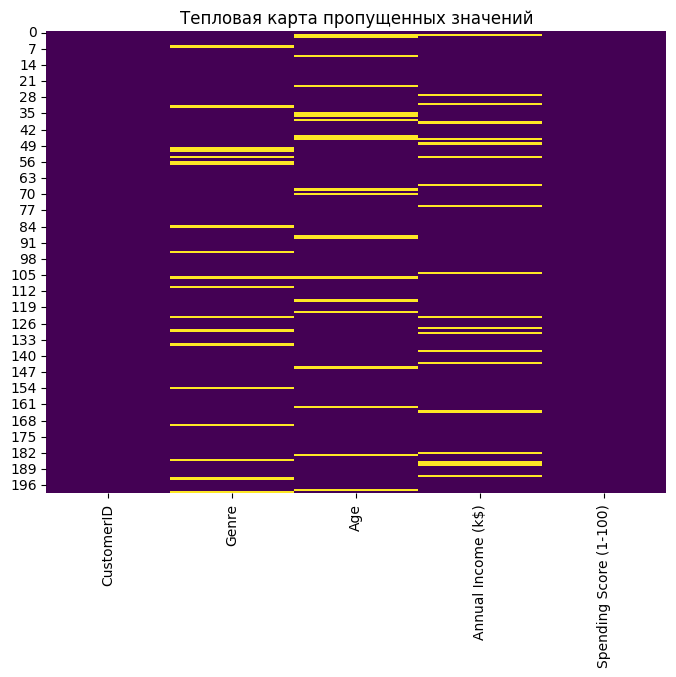

In [10]:
# Визуализация пропущенных значений (тепловая карта)
plt.figure(figsize=(8, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Тепловая карта пропущенных значений')
plt.show()

Из тепловой матрицы и проверок на пустые, NaN значения видно, что столбики Genre, Age и Annual Income (k$) имеют пропуски/NaN значения.
Количество пропущеных значений:

Genre                     19 шт

Age                       20 шт

Annual Income (k$)        20 шт

##### Исследуем данные по колонкам:

In [11]:
# Удаляем столбец CustomerID 
df = df.drop('CustomerID', axis=1)

Данный столбец CustomerID содержит индивидуальный номер клиента в порядке нумерации от 0 до 199 и не имеет ценности для построения модели или для анализа данных.

In [12]:
# Уникальные значения и их количество Genre
df['Genre'].value_counts()

Genre
Female     102
Male        77
Feemale      2
Name: count, dtype: int64

Данный столбец содержит три уникальных пола, причём третий похоже был введён ошибочно, опечатка при заполнениии DF. Также скорее всего имя самого столбца содержит ошибку, однако я её не буду исправлять поскольку таким образом можно повредить фильтры или программный код который опирается на неправильное название, перед исправлением название колонки должна быть поставлена чёткая задача на данное исправление (согласование для бесперебойной работы с DF в последующем). В данной задаче не предусмотрено, что мы должны исправить наименование данного столбца.

In [13]:
# Исправление опечатки внутри столбца Genre
df['Genre'] = df['Genre'].replace({'Feemale': 'Female'})  

# Проверяем изменения
df['Genre'].value_counts()

Genre
Female    104
Male       77
Name: count, dtype: int64

Исправим опечатки внутри колонки Genre их всего две штуки в любом случае это бы сильно не повлиялобы на модель или анализ данных.

In [14]:
# Уникальные значения и их количество Age
df['Age'].value_counts()

Age
32.0     10
35.0      8
31.0      7
30.0      7
49.0      7
19.0      6
40.0      6
47.0      6
23.0      6
27.0      6
36.0      5
38.0      5
48.0      5
20.0      4
59.0      4
18.0      4
34.0      4
29.0      4
54.0      4
37.0      3
60.0      3
43.0      3
67.0      3
25.0      3
39.0      3
50.0      3
46.0      3
33.0      3
28.0      3
22.0      3
24.0      3
45.0      3
21.0      3
68.0      3
44.0      2
57.0      2
26.0      2
51.0      2
52.0      2
135.0     2
58.0      2
65.0      2
53.0      2
41.0      2
63.0      1
70.0      1
69.0      1
55.0      1
66.0      1
56.0      1
42.0      1
Name: count, dtype: int64

In [15]:
# Уникальные значения и их количество Annual Income (k$)
df['Annual Income (k$)'].value_counts()

Annual Income (k$)
54.0     11
78.0     11
63.0      6
60.0      6
87.0      6
         ..
37.0      1
113.0     1
69.0      1
76.0      1
15.0      1
Name: count, Length: 64, dtype: int64

In [16]:
# Уникальные значения и их количество Spending Score (1-100)
df['Spending Score (1-100)'].value_counts()

Spending Score (1-100)
42    8
55    7
46    6
73    6
35    5
     ..
31    1
44    1
53    1
65    1
18    1
Name: count, Length: 84, dtype: int64

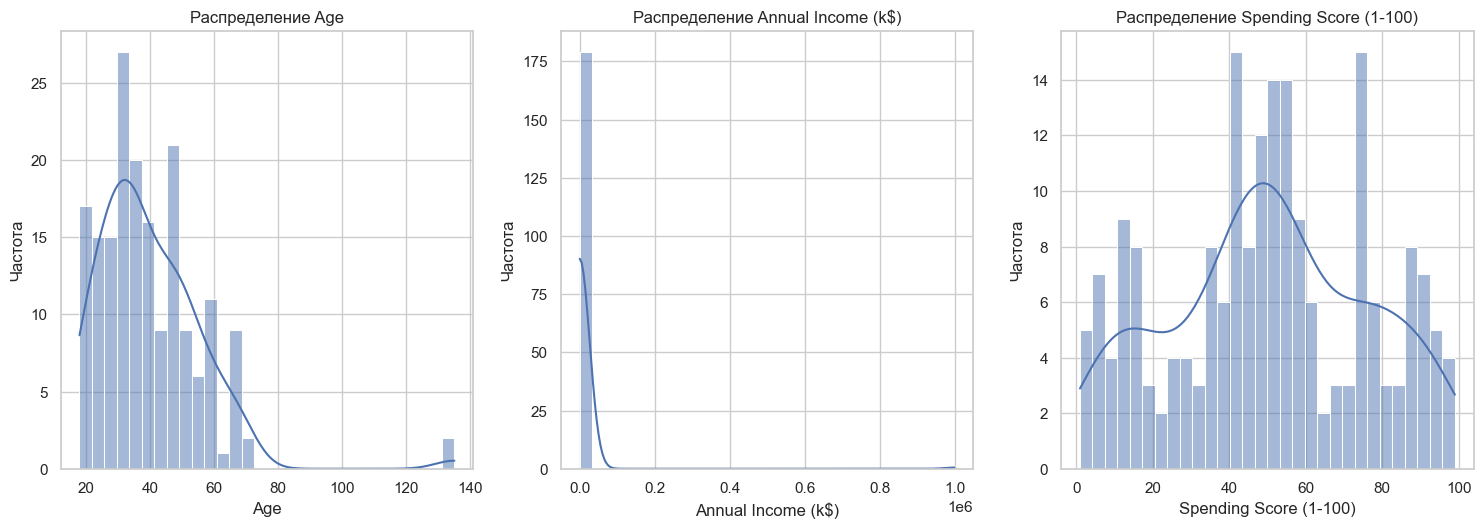

In [17]:
# Установка стиля графиков
sns.set(style="whitegrid")

# Визуализация распределения нескольких выбранных числовых переменных
selected_columns = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

plt.figure(figsize=(15, 10))

for i, column in enumerate(selected_columns):
    plt.subplot(2, 3, i + 1)
    sns.histplot(df[column], kde=True, bins=30)
    plt.title(f'Распределение {column}')
    plt.xlabel(column)
    plt.ylabel('Частота')

plt.tight_layout()
plt.show()

Age — график имеет резкое коолонообразное начало с лева и длинный хвост в право, что говорит о большом количестве клиетов в молодом возрасте. Пик клиентов приходится на возраст от 25 до 36 лет, затем происходит плавный спад выраженый выбросом в 135 лет, что срее всего просто опечатка и единица что следует из графика явно лишняя, скорее всего клиенты в выбросе имеют возраст около 35 лет.

Annual Income (k$) — доход имеет явный пик с небольшим выбросом в конце. Это говорит о том, что лишь очень небольшое количество граждан имеет высокий доход, остальные обладают средним доходом.

Spending Score (1-100) - Данные распределены более менее равномерно диаграма имеет два пика, что говорит нам о том, что есть две группы клиетов которые хорошо тратят свои деньги. В первом пике от 5 до 15 находятся первая группа клиентов которая не смотря на небольшое количество балов, затем идёт второй пик клиентов от 40 до 60 балов которые больше всего совершают покупок, затем идёт низподающая в право. Из этого можно сделать вывод, что часть клиентов у которых, есть первые накопления стараются как можно быстрее потратить свои балы, поскольку не так часто покупает, что либо, основная часть клиентов старается накопить побольше балов перед покупкой, и оставшиеся часть долго копит балы и совершает покупки лишь когда есть возможность ощутимой скидки это видно на спадающем пике где колона покупок в районе от 77 до 78 так же высока как на максимальном пике.

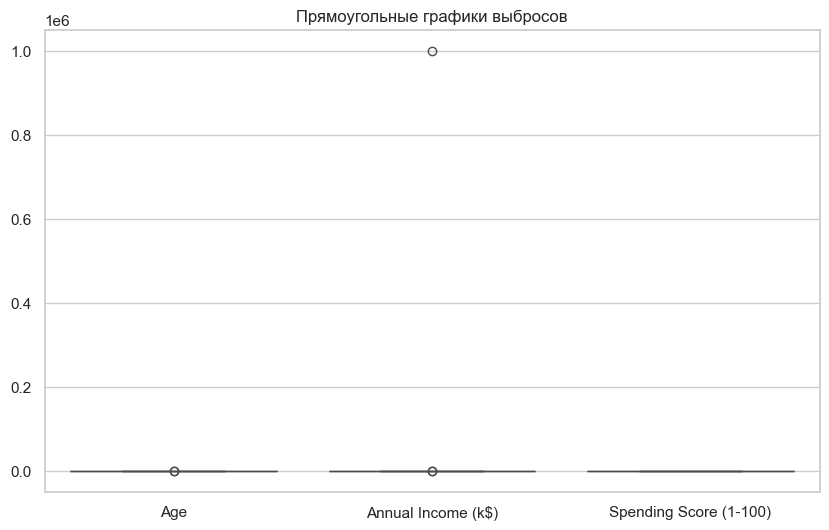

In [18]:
# Прямоугольные графики для визуализации распределений и потенциальных выбросов
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']])
plt.title("Прямоугольные графики выбросов")
plt.show()

В колонках Age и Annual Income (k$) наблюдаются выбросы, причём в последней достаточно серьёзный.

C:\Users\Esdesu\AppData\Local\Temp\ipykernel_13264\3025921178.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Genre', data=df, palette='Set2')


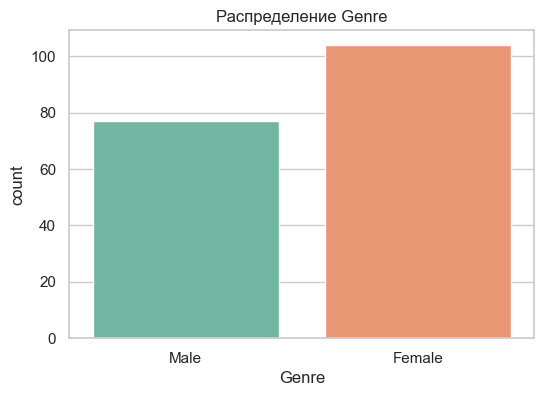

In [19]:
# Проверка баланса категириональных признаков
plt.figure(figsize=(6, 4))
sns.countplot(x='Genre', data=df, palette='Set2')
plt.title("Распределение Genre")
plt.show()

Можем наблюдать что сильный дисбаланс между классами отсуствует, благодаря тому, что мы исправили опечатки.

### Задание 3

Разделите данные на обучающую и тестовую выборки в пропорции 80:20. Здесь и далее используйте random_state = 1.

In [20]:
# Определение независимых и зависимых переменных
X = df.drop(["Spending Score (1-100)"], axis=1) # Независимые переменные
y = df['Spending Score (1-100)']  # Зависимая переменная

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Выводим размеры
print("Размер обучающего набора:", X_train.shape)
print("Размер тестового набора:", X_test.shape)

Размер обучающего набора: (160, 3)
Размер тестового набора: (40, 3)


### Задание 4

Заполните пропуски в признаках в обучающей выборке с использованием инструментов sklearn. 

Для каждого признака выберите и аргументируйте стратегию заполнения пропусков.

In [21]:
# Заполнение пропусков в 'Genre' с использованием моды
genre_median = SimpleImputer(strategy='most_frequent')
X_train['Genre'] = genre_median.fit_transform(X_train['Genre'].values.reshape(-1, 1)).ravel()

# Заполнение пропусков в 'Age' и 'Annual Income (k$)' с использованием медианы
other_median = SimpleImputer(strategy='median')
X_train[['Age', 'Annual Income (k$)']] = other_median.fit_transform(X_train[['Age', 'Annual Income (k$)']])

# Проверка результата
print(X_train.isnull().sum())

Genre                 0
Age                   0
Annual Income (k$)    0
dtype: int64


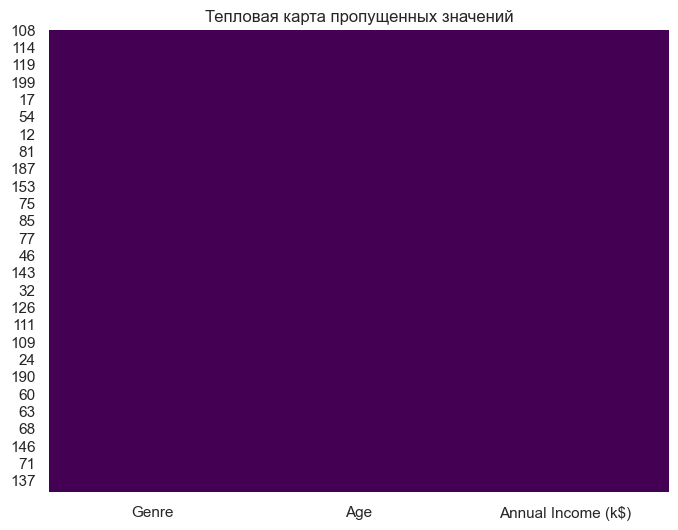

In [22]:
# Визуализация пропущенных значений (тепловая карта)
plt.figure(figsize=(8, 6))
sns.heatmap(X_train.isnull(), cbar=False, cmap='viridis')
plt.title('Тепловая карта пропущенных значений')
plt.show()

Genre - поскольку это категорианальный признак заполнение модой позволит сохранить наиболее часто врстречающееся значение.

Age и Anual Income (k$) - Средние значние может быть чувствительно к выбросам которые наблюдаются в обоих колонках, по этому лучше использовать медиану, которая более устойчива к аномалиям.

### Задание 5

Найдите выбросы в признаках обучающей выборки. 

Замените выбросы, если таковые имеются, и аргументируйте выбор метода поиска выбросов.

In [23]:
def replace_outliers_with_median(X_train, column):
    # Вычисление Q1 и Q3
    Q1 = X_train[column].quantile(0.25)
    Q3 = X_train[column].quantile(0.75)
    IQR = Q3 - Q1
    
    # Определение границ для выбросов
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Замена выбросов на медиану
    median_value = X_train[column].median()
    X_train[column] = np.where((X_train[column] < lower_bound) | (X_train[column] > upper_bound), median_value, X_train[column])

    # Подсчет выбросов
    outliers = X_train[(X_train[column] < lower_bound) | (X_train[column] > upper_bound)]
    return outliers.shape[0]  

# Применение функции к каждому столбцу
for col in ['Age', 'Annual Income (k$)']:
    replace_outliers_with_median(X_train, col)

In [24]:
age_outliers = replace_outliers_with_median(X_train, 'Age')
print(f"Количество выбросов в столбце 'Age': {age_outliers}")

annual_outliers = replace_outliers_with_median(X_train, 'Annual Income (k$)')
print(f"Количество выбросов в столбце 'Annual Income (k$)': {annual_outliers}")

Количество выбросов в столбце 'Age': 0
Количество выбросов в столбце 'Annual Income (k$)': 0


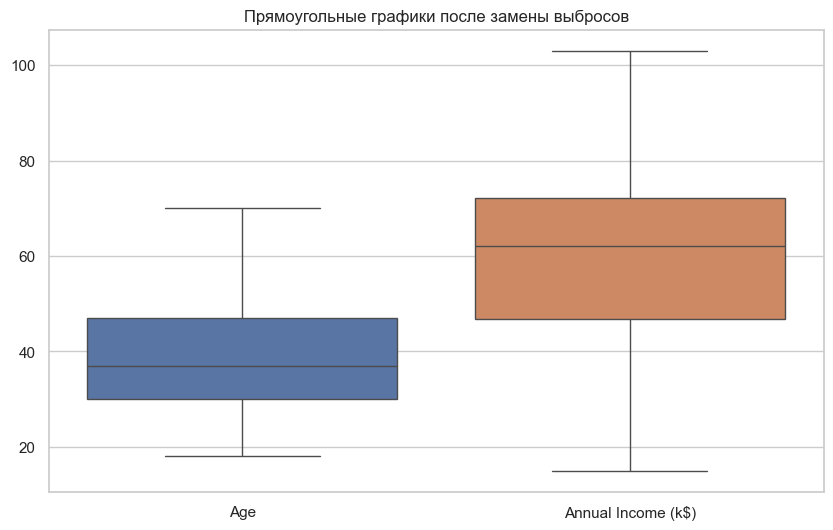

In [25]:
# Прямоугольные графики для визуализации распределений и потенциальных выбросов
plt.figure(figsize=(10, 6))
sns.boxplot(data=X_train[['Age', 'Annual Income (k$)']])
plt.title("Прямоугольные графики после замены выбросов")
plt.show()

Для поиска выбросов в признаках обучающей выборки можно использовать межквартильного диапазона (IQR). Этот метод позволяет выявить выбросы, основываясь на распределении данных.

Медиана позволяет избежать сильных искажений данных при замене выбросов.

### Задание 6

Нормализуйте численные признаки. 

Аргументируйте выбор стратегии нормализации для каждого признака.

In [26]:
# Функция для Z-нормализации
def z_normalize(column):
    return (column - column.mean()) / column.std()

# Функция для Мини-Max нормализации
def min_max_normalize(column):
    return (column - column.min()) / (column.max() - column.min())

# Нормализация признака Age (Z-нормализация)
X_train['Age'] = z_normalize(X_train['Age'])

# Нормализация признака Annual Income (k$) (Мини-Max нормализация)
X_train['Annual Income (k$)'] = min_max_normalize(X_train['Annual Income (k$)'])

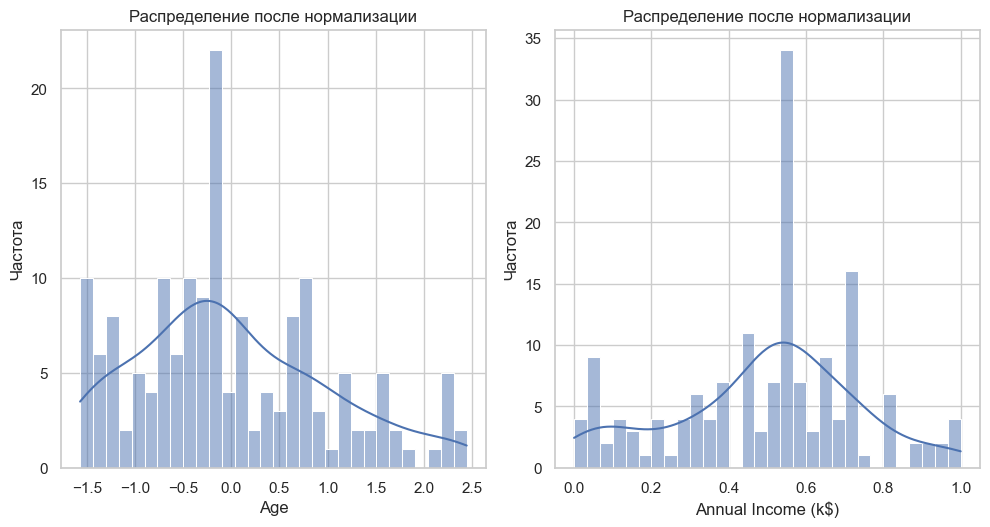

In [27]:
# Установка стиля графиков
sns.set(style="whitegrid")

# Визуализация распределения нескольких выбранных числовых переменных
selected_columns = ['Age', 'Annual Income (k$)']

plt.figure(figsize=(15, 10))

for i, column in enumerate(selected_columns):
    plt.subplot(2, 3, i + 1)
    sns.histplot(X_train[column], kde=True, bins=30)
    plt.title(f'Распределение после нормализации')
    plt.xlabel(column)
    plt.ylabel('Частота')

plt.tight_layout()
plt.show()

Age - может иметь нормальное распределение, и важно учитывать выбросы Z-нормализация позволит лучше обработать такие случаи, сохраняя информацию о вариации.

Annual Income (k$) - может иметь сильные выбросы (например, очень высокие доходы), что делает Z-нормализацию менее эффективной, так как она может быть сильно искажена. Мини-Max нормализация позволит поместить все значения в диапазон [0, 1], что может быть полезно для некоторых алгоритмов, таких как нейронные сети.

После выполнения кода получим нормализованные значения для признаков Age и Annual Income (k$). Это поможет улучшить результаты обучения моделей, так как алгоритмы машинного обучения часто чувствительны к масштабу признаков.

### Задание 7

Закодируйте категориальные признаки в обучающей выборке. 

Аргументируйте выбор способа кодирования.

In [28]:
# Создаем LabelEncoder
label_encoder = LabelEncoder()

# Кодируем колонку 'Genre'
X_train['Genre'] = label_encoder.fit_transform(X_train['Genre'])

# Выводим закодированные значения и соответствие
print("Закодированные значения:")
for original, encoded in zip(label_encoder.classes_, range(len(label_encoder.classes_))):
    print(f"{original} -> {encoded}")

Закодированные значения:
Female -> 0
Male -> 1


In [29]:
# Проверка результата
print(X_train[['Genre', 'Age', 'Annual Income (k$)']].head())
X_train.dtypes

     Genre       Age  Annual Income (k$)
108      1  2.288093            0.545455
107      1  1.208167            0.545455
189      0 -0.180309            1.000000
14       1 -0.103171            0.056818
56       0  0.976754            0.329545


Genre                   int32
Age                   float64
Annual Income (k$)    float64
dtype: object

C:\Users\Esdesu\AppData\Local\Temp\ipykernel_13264\2810187422.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Genre', data=X_train, order=X_train['Genre'].value_counts().index[::-1], palette='Set2')


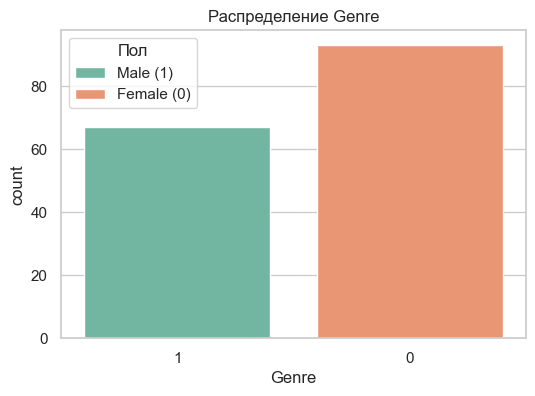

In [30]:
# Проверка баланса категориональных признаков
plt.figure(figsize=(6, 4))

# Инвертируем порядок категорий и задаем цвета
sns.countplot(x='Genre', data=X_train, order=X_train['Genre'].value_counts().index[::-1], palette='Set2')
plt.title("Распределение Genre")

# Добавляем легенду
plt.legend(title='Пол', labels=['Male (1)', 'Female (0)'])
plt.show()

В идеале надо бы использовать One-Hot Encoding поскольку он предотратит введелние ложного порядка в данные, однако проверив кодирование через Label Encoding после проверки этого не было выялено, так же можно использовать ручную замену категориальных значений.

### Задание 8
Проведите очистку и подготовку тестовых данных. 

Используйте препроцессоры и другие инструменты, которые вы уже использовали при подготовке обучающей выборки, без их дополнительной настройки.

In [31]:
# Проверка на пропущенные NaN значения
print(X_test.isnull().sum())

Genre                 4
Age                   5
Annual Income (k$)    2
dtype: int64


In [32]:
# 1. Замена пропущенных значений

# Заполнение пропущенных значений модой для категориальных признаков
X_test['Genre'] = X_test['Genre'].fillna(X_test['Genre'].mode()[0])

# Заполнение пропущенных значений средними значениями для числовых признаков
X_test['Age'] = X_test['Age'].fillna(X_test['Age'].mean())
X_test['Annual Income (k$)'] = X_test['Annual Income (k$)'].fillna(X_test['Annual Income (k$)'].mean())

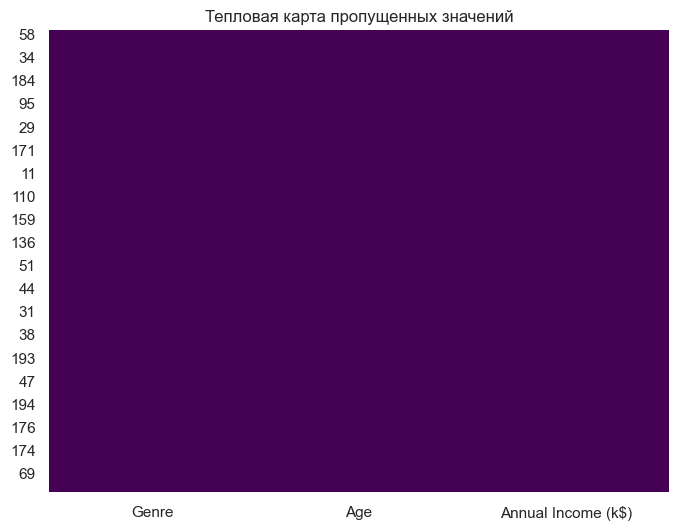

In [33]:
# Визуализация пропущенных значений (тепловая карта)
plt.figure(figsize=(8, 6))
sns.heatmap(X_test.isnull(), cbar=False, cmap='viridis')
plt.title('Тепловая карта пропущенных значений')
plt.show()

In [34]:
# 2. Нахождение и замена выбросов

# Определение нижней и верхней границ выбросов для возраста
lower_bound_age = X_test['Age'].quantile(0.05)  # 5-й процентиль
upper_bound_age = X_test['Age'].quantile(0.95)  # 95-й процентиль

# Замена значений ниже 5-го и выше 95-го процентилей на соответствующие квантильные значения
X_test.loc[X_test['Age'] < lower_bound_age, 'Age'] = lower_bound_age
X_test.loc[X_test['Age'] > upper_bound_age, 'Age'] = upper_bound_age

# Определение верхней границы выбросов для годового дохода
income_upper_limit = X_test['Annual Income (k$)'].quantile(0.95)

# Замена значений выше 95-го процентиля на это значение
X_test.loc[X_test['Annual Income (k$)'] > income_upper_limit, 'Annual Income (k$)'] = income_upper_limit

# Проверка результатов
print(X_test[['Age', 'Annual Income (k$)']].describe())

             Age  Annual Income (k$)
count  40.000000           40.000000
mean   40.218929           60.584605
std    11.853199           27.170108
min    23.950000           17.000000
25%    31.750000           38.750000
50%    39.000000           60.000000
75%    49.000000           85.500000
max    65.000000          113.350000


In [35]:
# 3. Нормализация численных признаков

# Создаем StandardScaler
scaler = StandardScaler()

# Применяем масштабирование только к числовым признакам
X_test[['Age', 'Annual Income (k$)']] = scaler.fit_transform(X_test[['Age', 'Annual Income (k$)']])

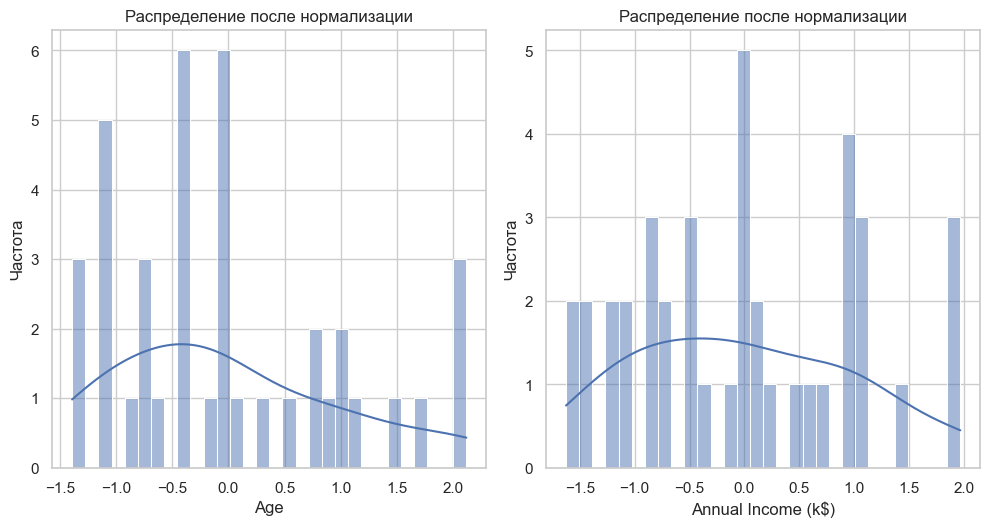

In [36]:
# Установка стиля графиков
sns.set(style="whitegrid")

# Визуализация распределения нескольких выбранных числовых переменных
selected_columns = ['Age', 'Annual Income (k$)']

plt.figure(figsize=(15, 10))

for i, column in enumerate(selected_columns):
    plt.subplot(2, 3, i + 1)
    sns.histplot(X_test[column], kde=True, bins=30)
    plt.title(f'Распределение после нормализации')
    plt.xlabel(column)
    plt.ylabel('Частота')

plt.tight_layout()
plt.show()

In [37]:
# 4. Кодирование категориальных признаков

# One-Hot Encoding для гендерного признака
encoded_genre = pd.get_dummies(X_test['Genre'], prefix='Genre', drop_first=True)

# Заменяем оригинальный столбец 'Genre' закодированным значением
X_test['Genre'] = encoded_genre

In [38]:
X_test['Genre'].value_counts()

Genre
False    30
True     10
Name: count, dtype: int64